# AutoML and Timeseries Meetup - Hands On

https://github.com/NeuralAlgorithms/firefly-tutorials/tree/master/meetup_automl_timeseries


## Setup

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import RidgeCV, ARDRegression, ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.base import BaseEstimator, RegressorMixin
from tsfresh.feature_extraction.feature_calculators import mean, variance, number_peaks, approximate_entropy, median, \
    fft_coefficient, cwt_coefficients,  autocorrelation

## Example Time Series Data Set

              AEP_MW
count  121273.000000
mean    15499.513717
std      2591.399065
min      9581.000000
25%     13630.000000
50%     15310.000000
75%     17200.000000
max     25695.000000
Average time step: 0 days 01:00:00


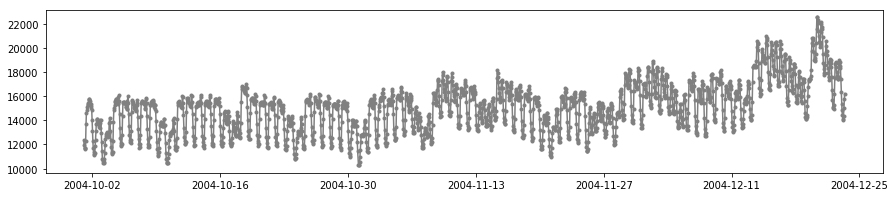

In [2]:
start_sample = 0
end_sample = 2000

df = pd.read_csv('data/AEP_hourly.csv', parse_dates=['Datetime'])

# sort dates ascending
df = df.set_index(['Datetime'])
df = df.sort_index()
df = df.reset_index()

print(df.describe())

t = df.Datetime[start_sample:end_sample]
y = df.AEP_MW[start_sample:end_sample]

plt.figure(figsize=(15,3))
plt.plot(t, y, '.-', c='gray')

t_diff_median = t.diff().median()
print('Average time step: {!s}'.format(t_diff_median))

## Hyperparameters  Wrappers

In [3]:
class HyperParameter():
    def __init__(self, name, min_value, max_value, discrete = False):
        self.name = name
        self.mn = min_value
        self.mx = max_value
        self.discrete = discrete
        self.random_state = np.random.RandomState()

    def random_value(self):
        if self.discrete:
            value = self.random_state.randint(self.mn, self.mx+1)
        else:
            value = self.random_state.rand()*(self.mx - self.mn) + self.mn

        return value


class ConfigSpace(object):

    @classmethod
    def get_random_configuration(cls, target_cls):
        out_config = {}
        for hp in target_cls.get_hyperparameters():
            out_config[hp.name] = hp.random_value()

        return out_config


## Estimators Wrappers

In [4]:
class EstimatorBase():
    cls = None

    def __init__(self, **kwargs):
        self.estimator = self.cls(**kwargs)

    def fit(self, x, y):
        self.estimator.fit(x, y)

    def predict(self, x):
        return self.estimator.predict(x)

    @classmethod
    def get_hyperparameters(cls):
        raise NotImplementedError("abstract function")
    
    @classmethod
    def get_random_configuration(cls):
        out_config = {}

        for hp in cls.get_hyperparameters():
            out_config[hp.name] = hp.random_value()

        return out_config

    @classmethod
    def get_random_instance(cls):
        return cls(**cls.get_random_configuration())

class RandomForestWrapper(EstimatorBase):
    cls = RandomForestRegressor
    def __init__(self, **kwargs):
        if 'n_jobs' not in kwargs:
            kwargs['n_jobs'] = 3
        super(RandomForestWrapper, self).__init__(**kwargs)

    @classmethod
    def get_hyperparameters(cls):
        n_estimators = HyperParameter(name='n_estimators', min_value=10,
                                      max_value=100, discrete=True)
        max_depth = HyperParameter(name='max_depth', min_value=4,
                                   max_value=30, discrete=True)
        return [n_estimators, max_depth]


class ElasticNetWrapper(EstimatorBase):
    cls = ElasticNet

    def __init__(self, **kwargs):
        if 'tol' not in kwargs:
            kwargs['tol'] = np.power(10, kwargs['tol'])

        super(ElasticNetWrapper, self).__init__(**kwargs)

    @classmethod
    def get_hyperparameters(cls):
        alpha = HyperParameter(name='alpha', min_value=0, max_value=2, discrete=False)
        l1_ratio = HyperParameter(name='l1_ratio', min_value=0, max_value=1, discrete=False)
        tol = HyperParameter(name='tol', min_value=-4, max_value=-1,
                                  discrete=False)

        return [alpha, l1_ratio, tol]

## AutoML Experiemnts

In [5]:
def evaluate(X, y, estimator: EstimatorBase, validation_size=100, test_size=100):


    Xtrain = X[:-validation_size - test_size]
    Ytrain = y[:-validation_size - test_size]
    Xval = X[-validation_size - test_size:-test_size]
    Yval = y[-validation_size - test_size:-test_size]
    Xtest = X[-test_size:]
    Ytest = y[-test_size:]

    estimator.fit(Xtrain, Ytrain)

    test_predictions = estimator.predict(Xtest)
    val_predictions = estimator.predict(Xval)

    test_loss = mean_absolute_error(y_true=Ytest, y_pred=test_predictions)
    val_loss = mean_absolute_error(y_true=Yval, y_pred=val_predictions)
    return val_loss, test_loss

In [18]:
def run_experiments(T, Y, n_experiments, estimator_wrapper: EstimatorBase, features_cls):

    val_losses = []
    test_losses = []
    try_index = []
    best_val_loss = 1e100
    best_config = (None, None)
    
    all_configurations = []
    all_scores = []
    for i in range(n_experiments):
    
        print("Runing new experiment...")        

        preproc_config = ConfigSpace.get_random_configuration(features_cls)
        X, y = features_cls.run(T, Y, **preproc_config)

        # prepare new dataset each experiment
#         df_train = create_multivariate_data(window=preproc_config['ConstantFeature']['window_size'], 
#                                             n_lags=preproc_config['ConstantFeature']['n_lags'])
#         X = df_train.drop(['Datetime', 'AEP_MW', 'entropy'], axis=1)
#         y = df_train.AEP_MW

        estimator_kwargs = estimator_wrapper.get_random_configuration()
        estimator = estimator_wrapper(**estimator_kwargs)
        
#         X = preproc_config_space.run_configuration(t, y, preproc_config)

    
    


        val_loss, test_loss = evaluate(X, y,                                       
                                       estimator=estimator,
                                       validation_size=300,
                                       test_size=300)
        
        merged_config = estimator_kwargs
        merged_config.update(preproc_config)
        all_configurations.append(merged_config)
        all_scores.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            val_losses.append(best_val_loss)
            test_losses.append(test_loss)
            try_index.append(i)
            best_config = (preproc_config, estimator_kwargs)
            print("Configuration: {}, {}". format(preproc_config, estimator_kwargs))
            print("experiment %d: Validation loss = %.3g, test loss = %.3g" % (i, val_loss, test_loss))

    print("Best validation loss = %.3g, test loss = %.3g" % (val_losses[-1], test_losses[-1]))
    print("Best config:\n%s\n%s" % best_config)
    
    plt.figure(1)
    plt.plot(try_index, val_losses, '.-b', try_index, test_losses, '.-r')
    plt.draw()
    
    
    df = pd.DataFrame(all_configurations)
    x = df.values
    y = all_scores
    rf = RandomForestRegressor(n_estimators=20)
    rf.fit(x, y)
    importances = rf.feature_importances_
    
    importances = pd.Series(importances, index=df.columns, name='Importance')
    importances.sort_values(ascending=False, inplace=True)
#     importances = importances[importances > 1e-15]
    display(importances.to_frame().style.bar())
    
    plt.figure(2)
    
    plt.show()
    
 

## Timeseries features hyperparameters wrapper

In [44]:
class TimeseriesFeatures():

    @classmethod
    def create_multivariate_data(cls, t, y, use_mean=0, use_median=0, use_variance=0, use_entropy=0, use_peaks=0, use_autocorrelation=0, window = 48, n_lags = 24):
        _mean = []
        _median = []
        _variance = []
        _entropy = []
        _peaks = []
        _autocorrelation = []
        dates = []
        values = []

        df = pd.DataFrame(y, columns=['AEP_MW'])
        df['Datetime'] = t
        
        df_sub = df[start_sample:end_sample]
        df_sub.index -= start_sample
        series_size = end_sample - start_sample
        for i in range(window+1, series_size):
            dates.append(df_sub.Datetime[i])
            values.append(df_sub.AEP_MW[i])
            if use_mean:
                _mean.append(np.mean(df_sub.AEP_MW[i-window:i]))
            if use_median:       
                _median.append(np.median(df_sub.AEP_MW[i-window:i]))
            if use_variance:
                _variance.append(variance(df_sub.AEP_MW[i-window:i]))            
            if use_entropy:
                _entropy.append(approximate_entropy(df_sub.AEP_MW[i-window:i], 10, 0.7))
            if use_peaks:
                _peaks.append(number_peaks(df_sub.AEP_MW[i-window:i], 3))
            if use_autocorrelation:
                _autocorrelation.append(autocorrelation(df_sub.AEP_MW[i-window:i], 1))


        # lags
        lags = {}
    #     n_lags = 20
        for i in range(1,n_lags):
            lags[i] = df_sub.AEP_MW.shift(i)


        df_lags = df_sub

        for i in range(1,n_lags):
            df_lags['lag' + str(i)] = 0

        for i in range(1,n_lags):
            df_lags['lag' + str(i)] = lags[i]

        # df_lags = df_lags.dropna()


        df_features = df_lags


        # additional statistical features
        df_features.AEP_MW = df_features.AEP_MW.astype(int)

        if use_mean:
            df_features['mean'] = _mean[0]
            df_features['mean'][window+1:series_size] = np.asarray(_mean)
        if use_median:            
            df_features['median'] = _median[0]
            df_features['median'][window+1:series_size] = np.asarray(_median)
        if use_variance:
            df_features['variance'] = _variance[0]
            df_features['variance'][window+1:series_size] = np.asarray(_variance)
        if use_entropy:
            df_features['entropy'] = _entropy[0]
            df_features['entropy'][window+1:series_size] = np.asarray(_entropy) 
        if use_peaks:
            df_features['peaks'] = _peaks[0]
            df_features['peaks'][window+1:series_size] = np.asarray(_peaks) 
        if use_autocorrelation:
            df_features['autocorrelation'] = _autocorrelation[0]
            df_features['autocorrelation'][window+1:series_size] = np.asarray(_autocorrelation) 
            
        df_features = df_features.dropna()


        df_train = df_features[window + 1:series_size]
        df_train['t'] = np.array([pd.to_datetime(value).value for value in df_train.Datetime]).reshape(-1,1)
        y = df_train.AEP_MW
        
        df_train.drop(['AEP_MW', 'Datetime'], inplace=True, axis=1)
        return df_train.values, y
    
    @classmethod
    def run(cls, t, y, **kwargs):
        return cls.create_multivariate_data(t, y, **kwargs)


    @classmethod
    def get_hyperparameters(cls):
        n_lags = HyperParameter(name='n_lags', min_value=1, max_value=5, discrete=True)
        window = HyperParameter(name='window', min_value=1, max_value=5, discrete=True)
                
        use_mean = HyperParameter(name='use_mean', min_value=0, max_value=1, discrete=True)
        
        return [n_lags, window, use_mean]
    
        
#         median = HyperParameter(name='median', min_value=0, max_value=1, discrete=True)
#         use_variance = HyperParameter(name='use_variance', min_value=0, max_value=1, discrete=True)
#         entropy = HyperParameter(name='entropy', min_value=0, max_value=1, discrete=True)
#         peaks = HyperParameter(name='peaks', min_value=0, max_value=1, discrete=True)
#         use_autocorrelation = HyperParameter(name='use_autocorrelation', min_value=0, max_value=1, discrete=True)
#         return [n_lags, window, mean, median, use_variance, entropy, peaks, use_autocorrelation]


## Experient preparations

Runing new experiment
Configuration: {'n_lags': 4, 'use_mean': 1, 'window': 2}, {'l1_ratio': 0.9950693899335328, 'use_mean': 1, 'window': 2, 'n_lags': 4, 'tol': -3.6722112384527783, 'alpha': 1.5645001171076276}
experiment 0: Validation loss = 272, test loss = 292
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Configuration: {'n_lags': 5, 'use_mean': 0, 'window': 5}, {'l1_ratio': 0.3085679879806811, 'use_mean': 0, 'window': 5, 'n_lags': 5, 'tol': -1.84621030750304, 'alpha': 0.6872861647173365}
experiment 6: Validation loss = 267, test loss = 299
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Runing new experiment
Best validation loss = 267, test loss = 299
Best config:
{'n_lags': 5, 'use_me

,Importance
n_lags,0.65351
tol,0.180516
alpha,0.145921
window,0.0185298
l1_ratio,0.00144145
use_mean,8.19407e-05


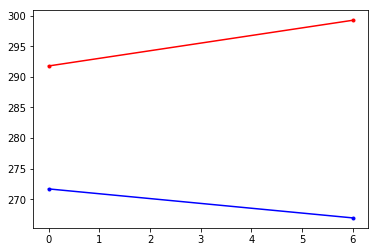

In [48]:


run_experiments(T=t, Y=y, n_experiments=20,
                    estimator_wrapper=ElasticNetWrapper,
                    features_cls=TimeseriesFeatures)


## Hands On Excercise

In [47]:
# Task 1: Change n_lags and window hyperparameter ranges

In [ ]:
# Task 2: Add Hyperparameters for use_median, use_variance, use_entropy, use_peaks, use_autocorrelation]

In [ ]:
# Task 3: Add new features such as day of week / is_weekend / 